<a href="https://colab.research.google.com/github/jersonvc/Data-Processing/blob/main/ProyectoCarlos/ProcesamientoConNucleo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import codecs

In [ ]:
###ACTUALIZAR EL TXT CON LOS NOMBRES DE LAS PROBETAS###
RutaDeEntrada = "/content/drive/MyDrive/Colab Notebooks/DatosConNucleoPosProcesado/"
RutaDeSalida = "/content/drive/MyDrive/Colab Notebooks/GraficaNucleoCabezal/"
RutaDeLectura = "/content/drive/MyDrive/Colab Notebooks/ListaBaseDeDataConNucleoPosProcesado.txt"

documento = codecs.open(RutaDeLectura, "r", "utf-8")
files = documento.readlines()

filenames = []
for i in range(len(files)):
  file = files[i]
  file = file[:9]
  filenames.insert(i,file)

fnames = []
for j in range(len(files)):
  f = files[j]
  f = f[:5]
  fnames.insert(j,f)

documento.close()

In [ ]:
###RAÍCES DEL POLINOMIO DE GRADO 5###
def PolGra5(c0, c1, c2, c3, c4, c5, xi, tol, y):
  xki = xi
  while True:
    xk = xki
    p_xk = c5*xk**5+c4*xk**4+c3*xk**3+c2*xk**2+c1*xk+c0-y
    pp_xk = 5*c5*xk**4+4*c4*xk**3+3*c3*xk**2+2*c2*xk+c1
    xki = xk-(p_xk/pp_xk)
    if abs(xki-xk)<tol:
        break
  return xki

In [ ]:
# datos = pd.DataFrame(index=np.arange(0, len(filenames), 1), columns=['filenames', 'uc', 'un', 'm4060', 'r', 'x40', 'x60', 'An', 'Ann'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

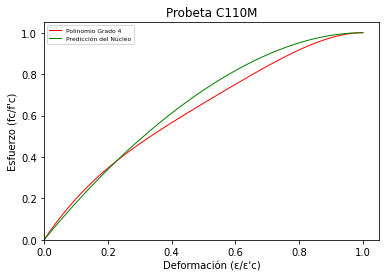

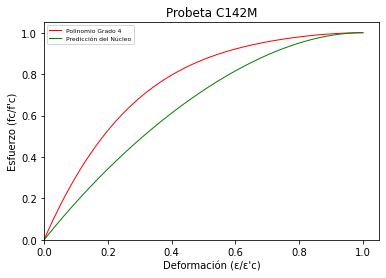

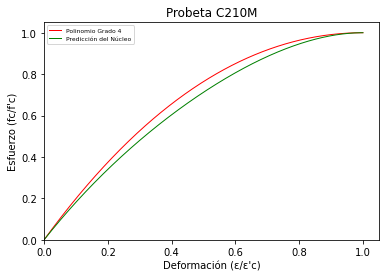

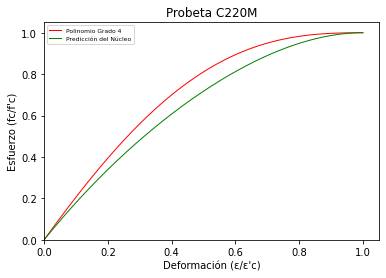

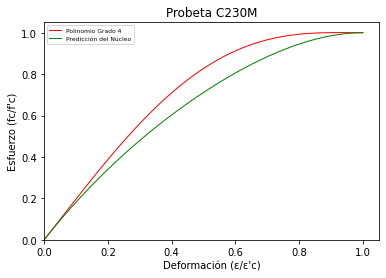

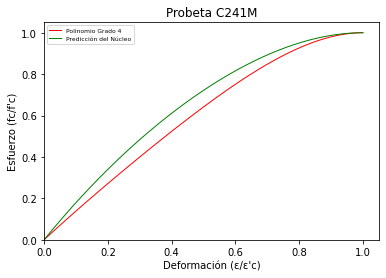

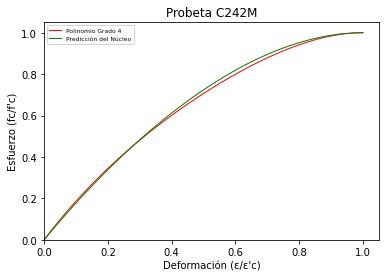

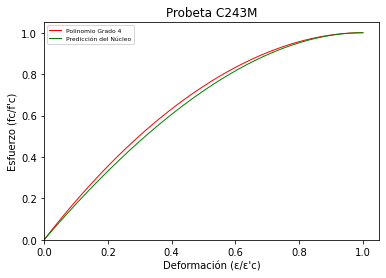

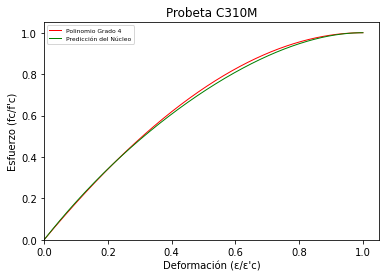

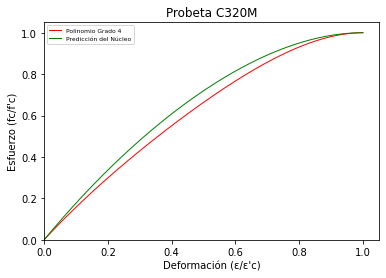

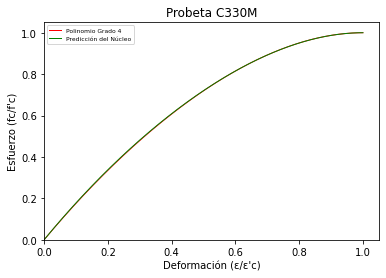

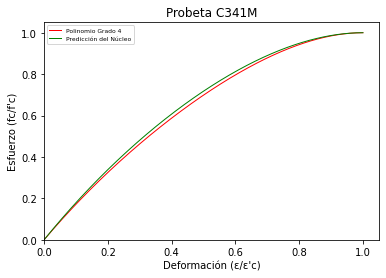

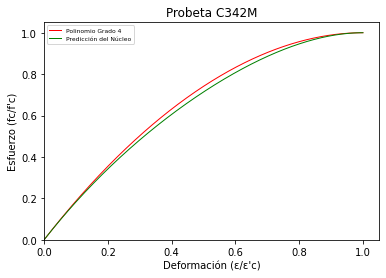

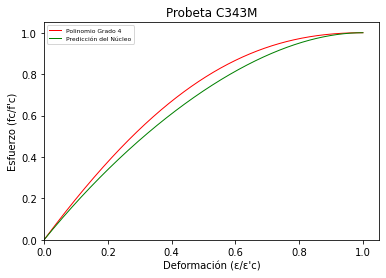

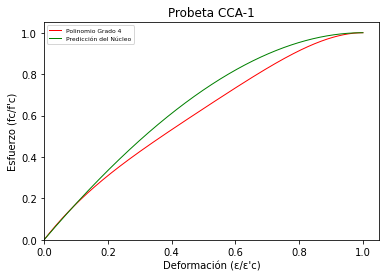

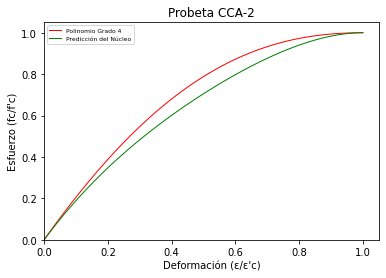

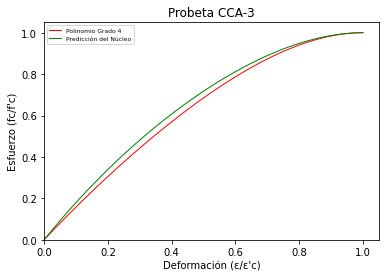

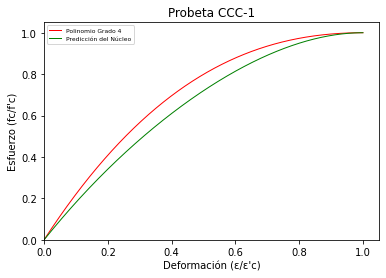

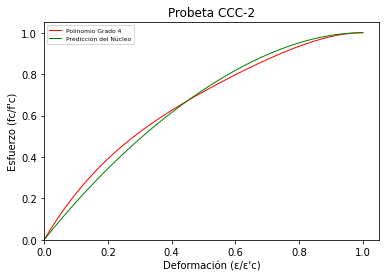

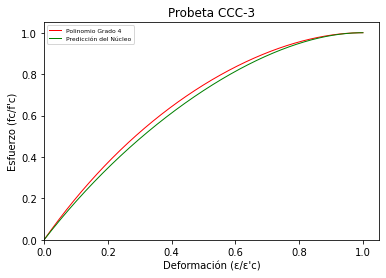

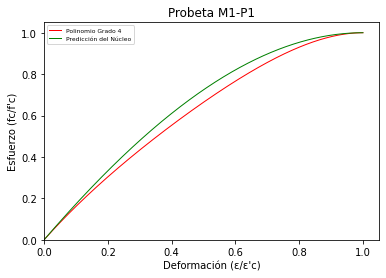

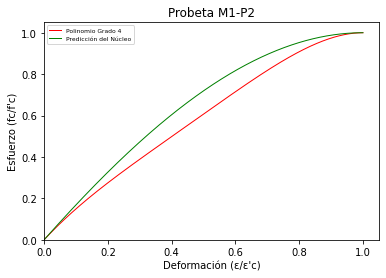

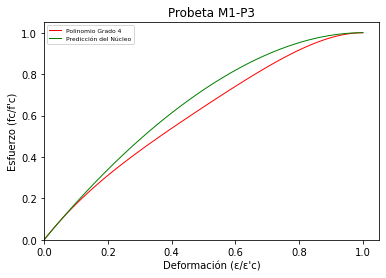

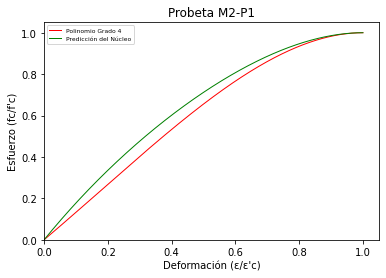

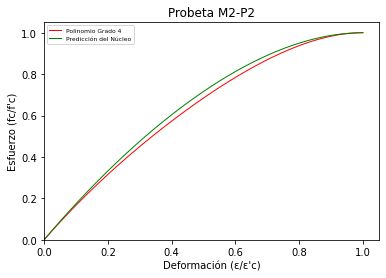

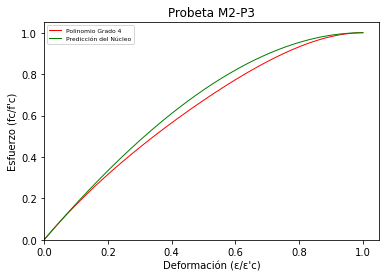

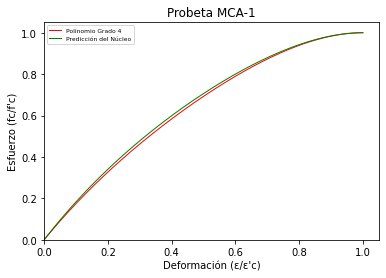

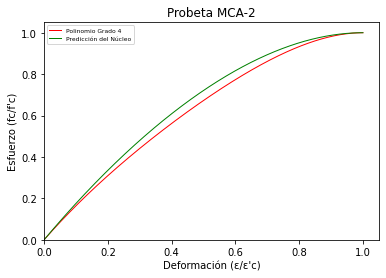

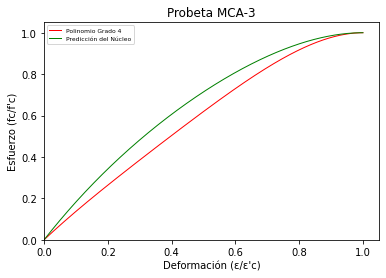

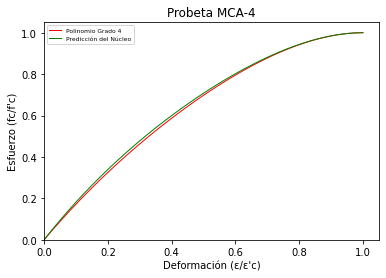

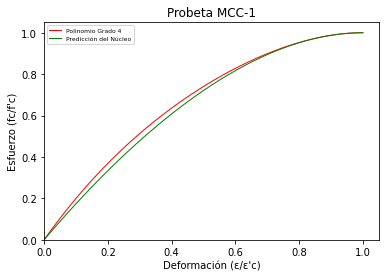

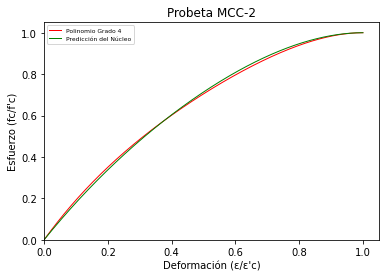

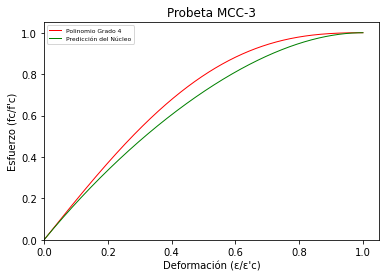

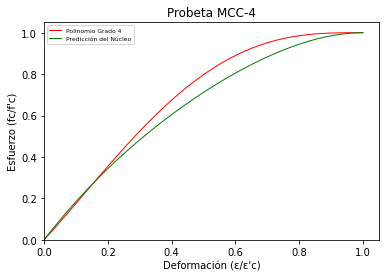

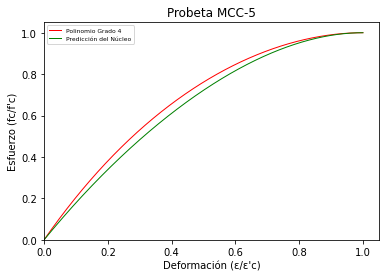

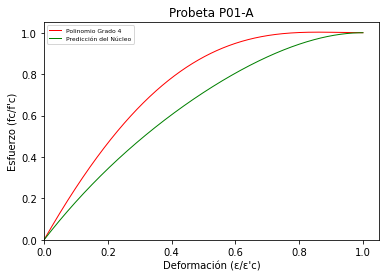

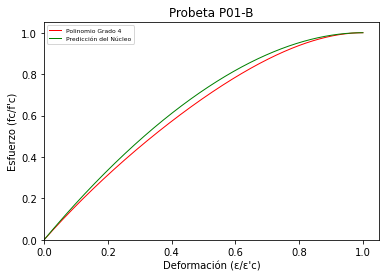

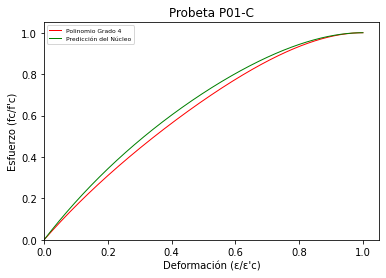

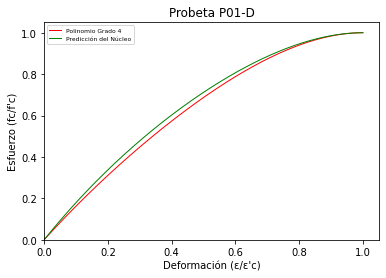

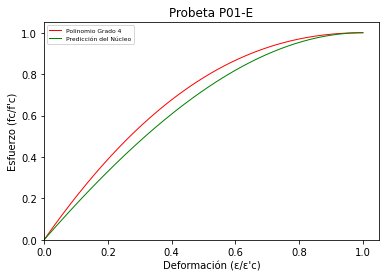

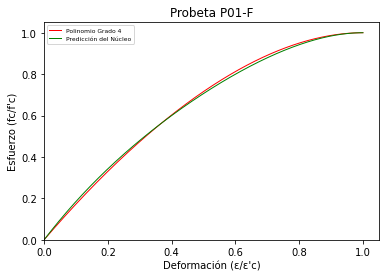

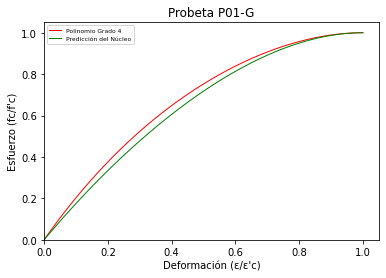

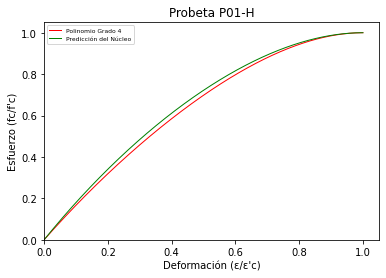

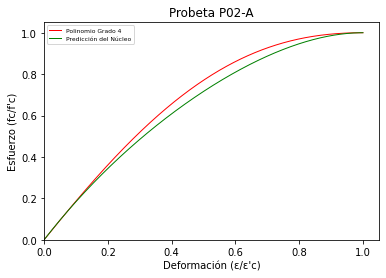

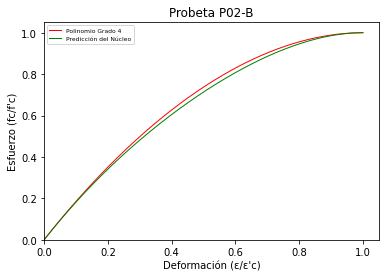

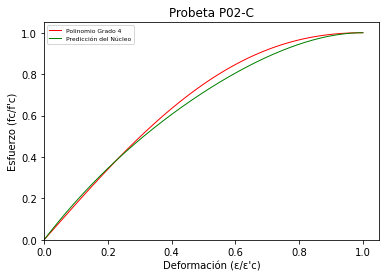

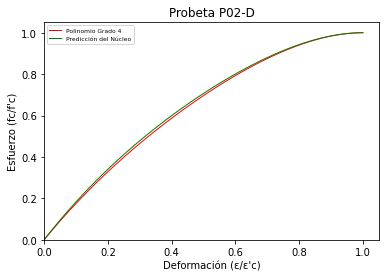

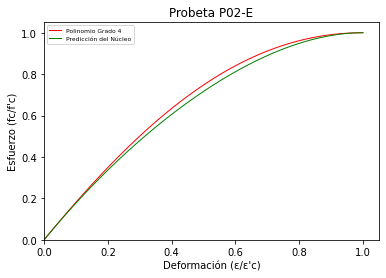

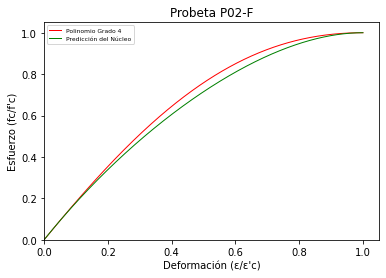

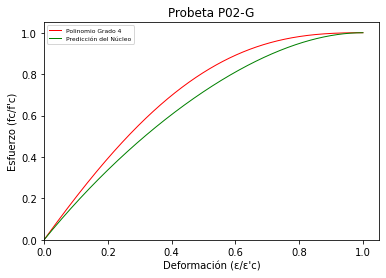

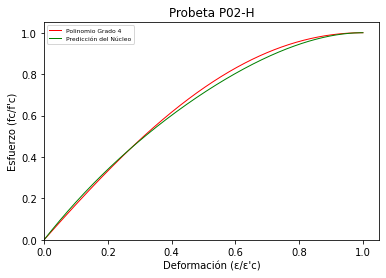

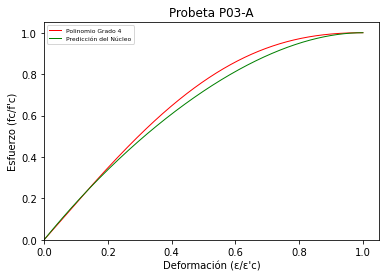

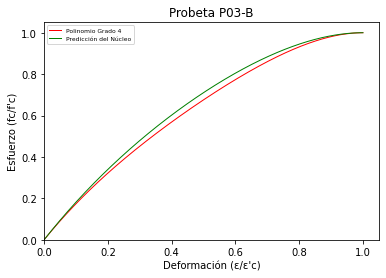

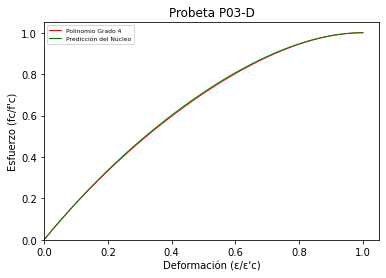

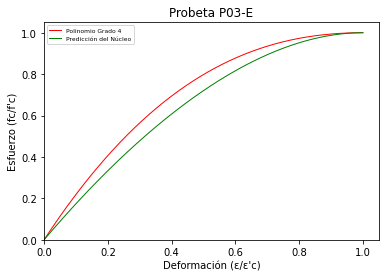

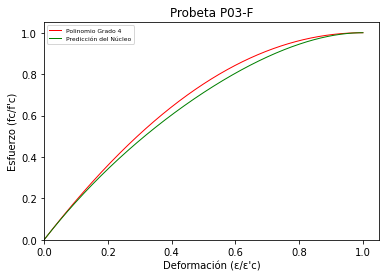

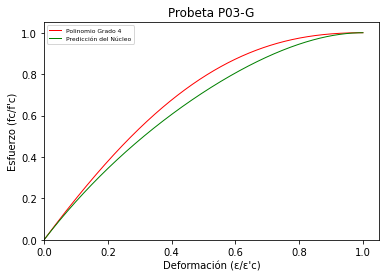

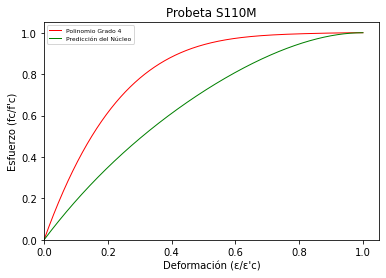

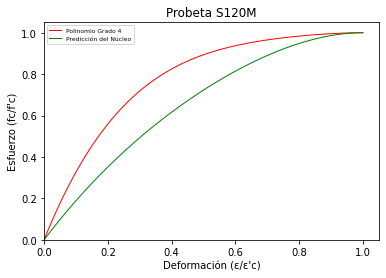

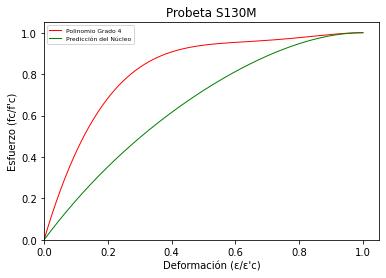

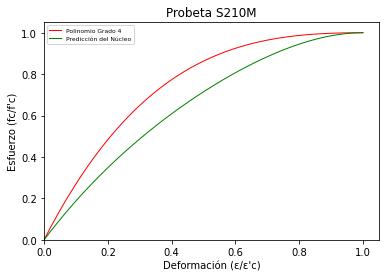

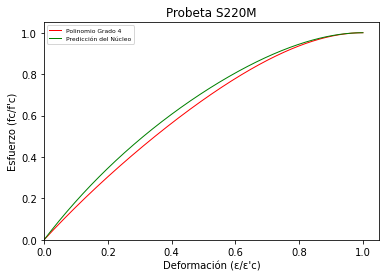

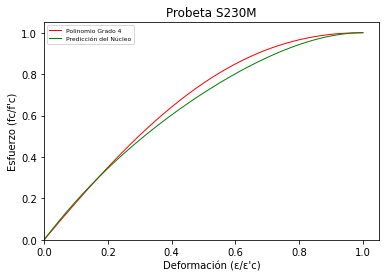

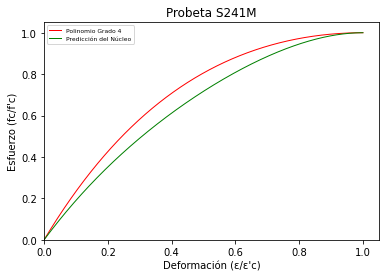

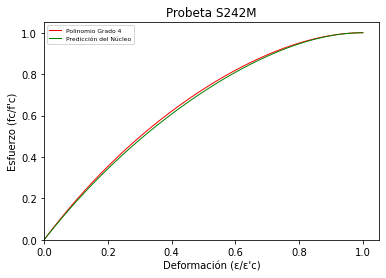

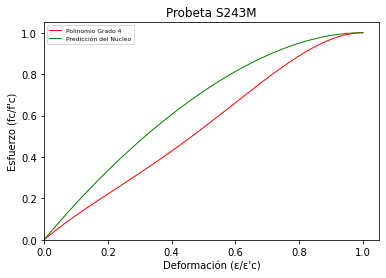

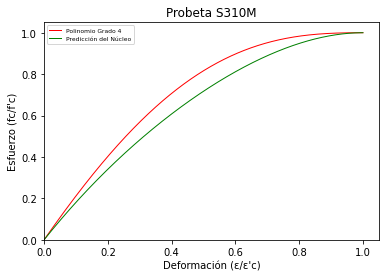

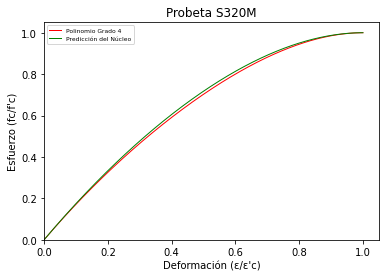

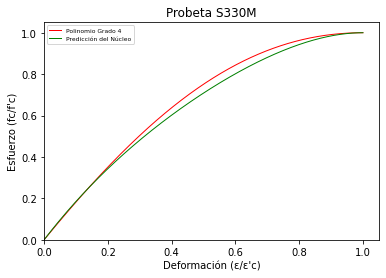

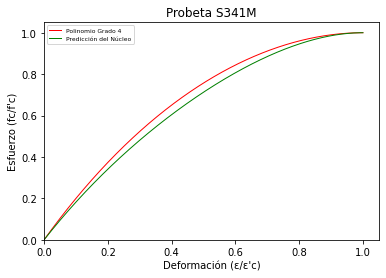

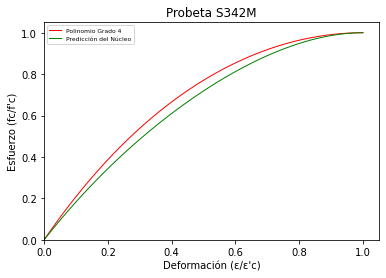

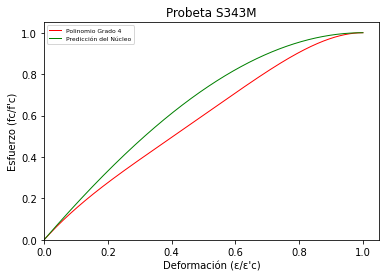

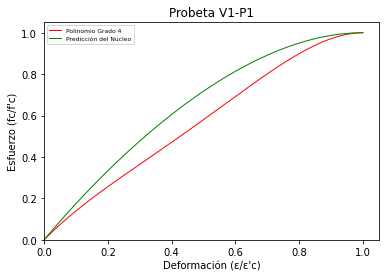

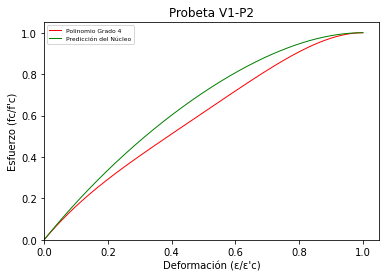

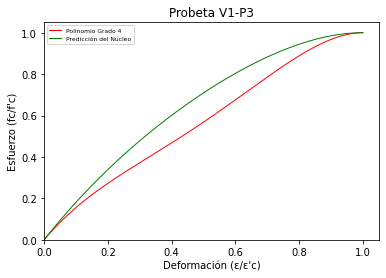

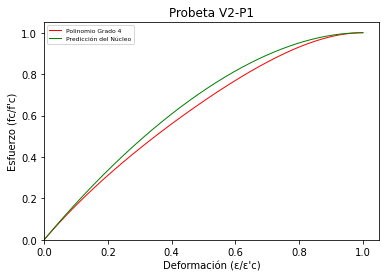

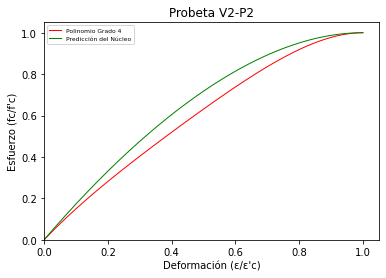

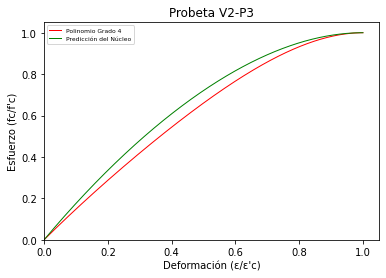

In [ ]:
for h in range(len(filenames)):
  df = pd.read_table(RutaDeEntrada+filenames[h], sep = '\t', names = ['step', 'date', 'ch0', 'ch1', 'ch2', 'ch3', 'ch4', 'cabezal', 'nucleo'], skiprows = 1, header = None, encoding = 'latin')

  loads = df[['ch0']].to_numpy()
  f = lambda x: (x-df.loc[0,'ch0'])
  loads = f(loads)

  dis_ch1 = df[['ch1']].to_numpy()
  dis_ch2 = df[['ch2']].to_numpy()
  dis_ch3 = df[['ch3']].to_numpy()
  dis_ch4 = df[['ch4']].to_numpy()

  dis_cabezal = []
  for i in range(len(loads)):
    dis_cabezal.insert(i,(dis_ch3[i]+dis_ch4[i])/2)

  dis_nucleo = []
  for i in range(len(loads)):
    dis_nucleo.insert(i,(dis_ch1[i]+dis_ch2[i])/2)

  mayor_load = loads[0]
  for i in range(len(loads)):
    if loads[i] > mayor_load:
      mayor_load = loads[i]
      posicion = i

  f = lambda x: x/mayor_load
  stress = f(loads)

  g = lambda x: x/dis_cabezal[posicion]
  strain_c = g(dis_cabezal)

  p = lambda x: x/dis_nucleo[posicion]
  strain_n = p(dis_nucleo)

  index = tuple(n for n in range(posicion + 1, len(stress)))
  stress = np.delete(stress, index)
  strain_c = np.delete(strain_c, index)
  strain_n = np.delete(strain_n, index)

  #PROCESAMIENTO DEL CABEZAL - POL DE GRADO 5#
  lista_a11 = []
  lista_a12 = []
  lista_a22 = []
  lista_b1 = []
  lista_b2 = []

  for i in range(len(stress)):
    lista_a11.insert(i,(-0.5*strain_c[i]**2+2*strain_c[i]**3-2.5*strain_c[i]**4+strain_c[i]**5)**2)
    lista_a12.insert(i,(-0.5*strain_c[i]**2+2*strain_c[i]**3-2.5*strain_c[i]**4+strain_c[i]**5)*(30*strain_c[i]**2-60*strain_c[i]**3+30*strain_c[i]**4))
    lista_a22.insert(i,(30*strain_c[i]**2-60*strain_c[i]**3+30*strain_c[i]**4)**2)
    lista_b1.insert(i,(-0.5*strain_c[i]**2+2*strain_c[i]**3-2.5*strain_c[i]**4+strain_c[i]**5)*(stress[i]+12*strain_c[i]**2-28*strain_c[i]**3+15*strain_c[i]**4))
    lista_b2.insert(i,(30*strain_c[i]**2-60*strain_c[i]**3+30*strain_c[i]**4)*(stress[i]+12*strain_c[i]**2-28*strain_c[i]**3+15*strain_c[i]**4))

  a11 = sum(lista_a11)
  a12 = sum(lista_a12)
  a21 = a12
  a22 = sum(lista_a22)
  b1 = sum(lista_b1)
  b2 = sum(lista_b2)

  A = np.matrix([[a11,a12],[a21,a22]])
  b = np.matrix([[b1],[b2]])

  parametros = np.linalg.solve(A,b)

  c5 = float(parametros[0])
  uc = float(parametros[1])

  c0 = 0
  c1 = 0
  c2 = -12+30*uc-0.5*c5
  c3 = 28-60*uc+2*c5
  c4 = -15+30*uc-2.5*c5
  c5 = c5
  x40 = PolGra5(c0, c1, c2, c3, c4, c5, 0.55, 10**(-6), 0.4)
  x60 = PolGra5(c0, c1, c2, c3, c4, c5, 0.7, 10**(-6), 0.6)
  m4060 = 0.2/(PolGra5(c0, c1, c2, c3, c4, c5, 0.7, 10**(-6), 0.6)-PolGra5(c0, c1, c2, c3, c4, c5, 0.55, 10**(-6), 0.4))

  xcc = np.linspace(0, 1, 1000)

  i = 0
  stress_cab = []
  for i in range(len(xcc)):
    stress_cab.insert(i,c0+c1*xcc[i]+c2*xcc[i]**2+c3*xcc[i]**3+c4*xcc[i]**4+c5*xcc[i]**5)

  ##PROCESAMIENTO DEL NUCLEO - POL DE GRADO 4#
  lista_a11 = []
  lista_a12 = []
  lista_a22 = []
  lista_b1 = []
  lista_b2 = []

  for i in range(len(stress)):
    lista_a11.insert(i,(strain_n[i]-4.5*strain_n[i]**2+6*strain_n[i]**3-2.5*strain_n[i]**4)**2)
    lista_a12.insert(i,(strain_n[i]-4.5*strain_n[i]**2+6*strain_n[i]**3-2.5*strain_n[i]**4)*(30*strain_n[i]**2-60*strain_n[i]**3+30*strain_n[i]**4))
    lista_a22.insert(i,(30*strain_n[i]**2-60*strain_n[i]**3+30*strain_n[i]**4)**2)
    lista_b1.insert(i,(strain_n[i]-4.5*strain_n[i]**2+6*strain_n[i]**3-2.5*strain_n[i]**4)*(stress[i]+12*strain_n[i]**2-28*strain_n[i]**3+15*strain_n[i]**4))
    lista_b2.insert(i,(30*strain_n[i]**2-60*strain_n[i]**3+30*strain_n[i]**4)*(stress[i]+12*strain_n[i]**2-28*strain_n[i]**3+15*strain_n[i]**4))

  a11 = sum(lista_a11)
  a12 = sum(lista_a12)
  a21 = a12
  a22 = sum(lista_a22)
  b1 = sum(lista_b1)
  b2 = sum(lista_b2)

  A = np.matrix([[a11,a12],[a21,a22]])
  b = np.matrix([[b1],[b2]])

  parametros = np.linalg.solve(A,b)

  r = float(parametros[0])
  un = float(parametros[1])

  n0 = 0
  n1 = r
  n2 = -12+30*un-4.5*r
  n3 = 28-60*un+6*r
  n4 = -15+30*un-2.5*r

  xnn = np.linspace(0, 1, 1000)

  i = 0
  stress_nuc = []
  for i in range(len(xnn)):
    stress_nuc.insert(i,n0+n1*xnn[i]+n2*xnn[i]**2+n3*xnn[i]**3+n4*xnn[i]**4)

  #CALCULO DEL NUCLEO/METODO#
  # un = 0.5151602963*np.exp(0.5016664082*uc)
  # r = 0.7598124641*np.exp(0.6743722986*m4060)
  un = 0.6227365393*np.exp(0.0814684787*uc)
  r = 1.2511931073*np.exp(0.2984790477*m4060)


  n0 = 0
  n1 = r
  n2 = -12+30*un-4.5*r
  n3 = 28-60*un+6*r
  n4 = -15+30*un-2.5*r

  i = 0
  stress_nuc_metodo = []
  for i in range(len(xnn)):
    stress_nuc_metodo.insert(i,n0+n1*xnn[i]+n2*xnn[i]**2+n3*xnn[i]**3+n4*xnn[i]**4)

  #GRÁFICA NUCLEO / CABEZAL / METODO#
  xn = strain_n
  xc = strain_c
  y = stress
  yn = stress_nuc
  yc = stress_cab
  ynn = stress_nuc_metodo
  fig, ax = plt.subplots()
  ax.set_title("Probeta "+fnames[h])
  plt.axis([0, 1.05, 0, 1.05])
  # ax.scatter(xn, y, s=3, c="#FF6A6A", label="Data Experimental - Núcleo")
  # ax.scatter(xc, y, s=3, c="#A7AEFE", label="Data Experimental - Cabezal")
  # ax.plot(xcc,yc, "b", lw=1, linestyle = "-", label="Polinomio Grado 5")
  ax.plot(xnn,yn, "r", lw=1, linestyle = "-", label="Polinomio Grado 4" )
  ax.plot(xnn,ynn, "g", lw=1, linestyle = "-", label="Predicción del Núcleo" )
  plt.xlabel("Deformación (ɛ/ɛ'c)")
  plt.ylabel("Esfuerzo (fc/f'c)")
  ax.legend(fontsize=6, loc='upper left')
  plt.savefig(RutaDeSalida+'Figura{0}-.jpg'.format(h+1))


#   datos.iloc[h] = [filenames[h], uc, un, m4060, r, x40, x60, An, Ann]
# datos.to_excel('Parametros_Con_Nucleo.xlsx', index = False)